In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy import stats
import pickle
import pandas as pd

plt.rcParams["figure.figsize"] = (15,10)
plt.style.use('seaborn')

In [9]:
# open the file of interest, and use pickle loading
infile = open ("qcd_100000_pt_1000_1200.pkl",'rb')
background_dict = pickle.load(infile)

# open the file of interest, and use pickle loading
infile = open ("higgs_100000_pt_1000_1200.pkl",'rb')
signal_dict = pickle.load(infile)

# list all keys of the files
keys = background_dict.keys()
print("The 14 features of this lab are "+str(keys.values))

The 14 features of this lab are ['pt' 'eta' 'phi' 'mass' 'ee2' 'ee3' 'd2' 'angularity' 't1' 't2' 't3'
 't21' 't32' 'KtDeltaR']


## Introduction

The following report attempts to calculate the significance of detecting the Higgs Boson by optimizing data cuts. This is performed in several steps, broadly explained as follows:

Simulated Data

1. Starting with mass as the feature variable, evaluate expected significance without any event selection. Then systematically make cuts through the data set to identify the optimal cuts. Repeat this for every variable of interest 
2. Use the optimal mass cuts to further slice the data and determine the optimal cuts and expected significance

Experimental Data

3. Compare the observed data with the expected simulation data with and without event selection
4. Use the optimal cuts determined in the simulation to determine the discovery significance

## Data Cuts

#### Feature Variable: Mass

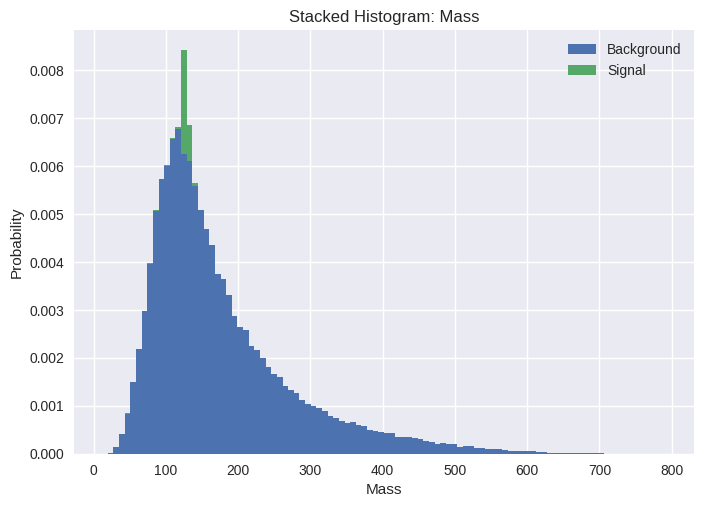

In [55]:
fig, ax = plt.subplots(1,1)

bkg_mass = background_dict['mass']
sig_mass = signal_dict['mass']

data = [bkg_mass, sig_mass]

n_background = 2000
n_signal = 50 

bkg_weight = np.array([n_background]*len(bkg_mass))
sig_weight = np.array([n_signal]*len(sig_mass))

a = ax.hist(data, bins=100, density=True, stacked=True, weights=[bkg_weight, sig_weight], label=["Background", "Signal"])

ax.set_xlabel("Mass")
ax.set_ylabel("Probability")
ax.set_title("Stacked Histogram: Mass")

plt.legend(loc=0)
plt.show()

The above plot shows the normalized density histogram of the experimental background and signal data. We can calculate the significance without any event selection using Poisson statistics and the expected number of events. The Poisson 'k' value is the excess of signal to background, while the mean 'mu' is the background.

In [56]:
expected_sig = stats.poisson.cdf(n_background + n_signal, n_background, loc=0)
print("The expected signficance with Poisson statistics is "+str(round(expected_sig,3)))

The expected signficance with Poisson statistics is 0.87


This can be compared to the approximation $N_{higgs} / \sqrt{N_{QCD}}$

In [57]:
sig = n_signal / np.sqrt(n_background)
print("The approximated significance is " +str(round(sig,2)))

The approximated significance is 1.12


To calculate the signifiance of each feature variable, we can use histograms. By iterating through each bin of a properly weighted histogram and comparing the number of background events to the number of signal events, we can begin to optimize event selection. I've chosen an arbitrary number of bins (100), histograms for the background and signal, and calculated the significance by counting the number of events in each bin. 

In [58]:
fig, ax = plt.subplots(1,1)
plt.close()

bins = 100

mass_min = bkg_mass.min()
mass_max = bkg_mass.max()

bkd_hist = ax.hist(bkg_mass, bins, range=[mass_min, mass_max], weights=bkg_weight / 100000, align='mid')
sig_hist = ax.hist(sig_mass, bins, range=[mass_min, mass_max], weights=sig_weight / 100000, align='mid')

In [59]:
expected_sig = []
for i in range(bins):
    qcd = bkd_hist[0][i] 
    higgs = sig_hist[0][i] 
    prob = stats.poisson.cdf(qcd+higgs, qcd, loc=0)
    expected_sig.append(stats.norm.ppf(prob, loc=0, scale=1))

expected_sig = np.array(expected_sig)
expected_sig[np.isinf(expected_sig)] = 0

bin_index = np.argmax(expected_sig)

print("The maximum significance for a mass histogram with 100 bins is "+str(round(expected_sig.max(),3))
      +" and occurs in bin "+str(bin_index)+", data range "+str(round(bkd_hist[1][bin_index],3))+"-"+str(round(bkd_hist[1][bin_index+1],3)))

The maximum significance for a mass histogram with 100 bins is 3.31 and occurs in bin 14, data range 121.18-128.98


#### Other Features, Constant Bin Size

The following plots show stacked density histograms of all features with bin size of 100.

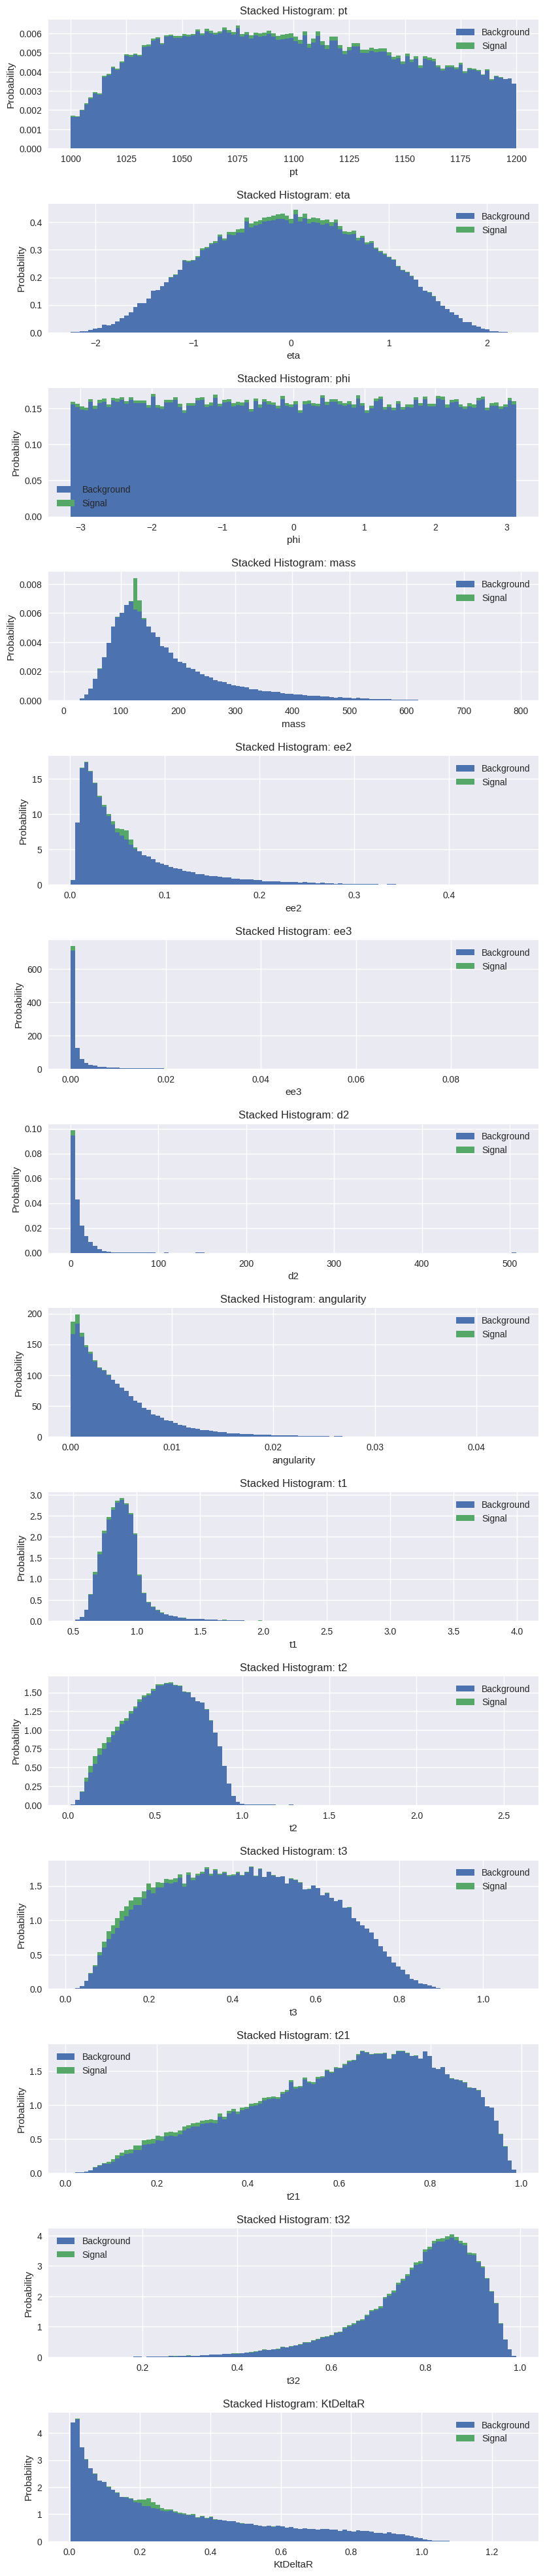

In [60]:
fig, ax = plt.subplots(len(keys), 1, figsize=(9,40))
fig.tight_layout(pad=4)

for i in range(len(keys)):

    bkg_i = background_dict[keys[i]]
    sig_i = signal_dict[keys[i]]

    data = [bkg_i, sig_i]
    
    bkg_weight = np.array([n_background]*len(bkg_i))
    sig_weight = np.array([n_signal]*len(sig_i))

    a = ax[i].hist(data, bins=100, density=True, stacked=True, weights=[bkg_weight, sig_weight], label=["Background", "Signal"])

    ax[i].set_xlabel(keys[i])
    ax[i].set_ylabel("Probability")
    ax[i].set_title("Stacked Histogram: "+str(keys[i]))

    ax[i].legend(loc=0)
plt.show()

From these histograms, we can calculate the maximum significance of each feature and its location without any data cuts.

In [63]:
bins = 100
expected_sig_array = np.zeros([len(keys), bins])
max_index = np.zeros(len(keys))
bkg_hist = np.zeros([len(keys), bins])

for i in range(len(keys)):
    bkg_i = background_dict[keys[i]]
    sig_i = signal_dict[keys[i]]
    
    bkg_min = bkg_i.min()
    bkg_max = bkg_i.max()

    data = [bkg_i, sig_i]
    
    bkg_hist_i = plt.hist(bkg_i, bins, range=[bkg_min, bkg_max], weights=bkg_weight / 100000)
    sig_hist_i = plt.hist(sig_i, bins, range=[bkg_min, bkg_max], weights=sig_weight / 100000)
    
    for j in range(bins):
        qcd = bkg_hist_i[0][j]
        higgs = sig_hist_i[0][j]
        prob = stats.poisson.cdf(qcd+higgs, qcd, loc=0)
        expected_sig = stats.norm.ppf(prob, loc=0, scale=1)
        expected_sig_array[i][j] = expected_sig
        
        expected_sig_array[np.isinf(expected_sig_array)] = 0
        
    max_index = np.argmax(expected_sig_array[i])
        
    print(str(keys[i])+": Highest sig "+str(round(expected_sig_array[i][max_index],2))+
          ", Location "+str(round(bkg_hist_i[1][max_index],2))+", Bin "+str(max_index))
    
    plt.close()

pt: Highest sig 0.34, Location 1000.0, Bin 0
eta: Highest sig 2.06, Location 2.21, Bin 98
phi: Highest sig 0.27, Location 2.51, Bin 90
mass: Highest sig 3.31, Location 121.18, Bin 14
ee2: Highest sig 2.06, Location 0.4, Bin 84
ee3: Highest sig 2.06, Location 0.05, Bin 54
d2: Highest sig 2.06, Location 86.36, Bin 17
angularity: Highest sig 2.06, Location 0.03, Bin 76
t1: Highest sig 2.06, Location 2.73, Bin 64
t2: Highest sig 2.06, Location 1.35, Bin 52
t3: Highest sig 2.06, Location 0.93, Bin 86
t21: Highest sig 1.43, Location 0.01, Bin 0
t32: Highest sig 2.06, Location 0.05, Bin 0
KtDeltaR: Highest sig 2.06, Location 1.13, Bin 89


The highest signficiance was mass with a value of 3.31.

#### All Features, Variable Bin Size

The following significances were calculated by varying the bin size from 0 to 100 and retaining the optimal bin number, the optimal bin within that number, and the highest significance obtained. If the maximum signficiance occurs with 1 bin, the maximum significance is over the entire data range.

In [66]:
n_higgs = 50
n_qcd = 2000

qcd = background_dict
higgs = signal_dict

fig, ax = plt.subplots(1,1)

j = 0
optimal_bin_num = []
for key in qcd:
    print(key + ":")
    n_higgs = 50
    n_qcd = 2000
    qcd_weight = np.array([n_qcd] * len(qcd[key]))
    higgs_weight = np.array([n_higgs] * len(higgs[key]))

    max_array = []
    for bin_num in range(1, 101, 1):

        lower_val = qcd[key].min()
        upper_val = qcd[key].max()

        hist_qcd = ax.hist(qcd[key], bins = bin_num, density = False, weights = [qcd_weight / 100000], range = (lower_val, upper_val))
        hist_higgs = ax.hist(higgs[key], bins = bin_num, density = False, weights = [higgs_weight / 100000], range = (lower_val, upper_val))

        cut_sigs = []
        for i in range(bin_num):
            n_qcd = hist_qcd[0][i]
            n_higgs = hist_higgs[0][i]
            sig = stats.norm.ppf(stats.poisson.cdf(n_higgs + n_qcd, n_qcd, loc = 0))
            cut_sigs.append(sig)
        
        cut_sigs = np.array(cut_sigs)
        cut_sigs[np.isinf(cut_sigs)] = 0
        
        index_max = np.argmax(cut_sigs)
        max_array.append([bin_num, cut_sigs[index_max], index_max])

    max_sig = max_array[0][1]
    ind = 0
    for k in range(len(max_array)):
        if abs(max_array[k][1]) > abs(max_sig):
            max_sig = max_array[k][1]
            ind = k

    optimal_bin_num.append(max_array[ind][0])
    bottom_val = lower_val + max_array[ind][2] * ((upper_val - lower_val) / max_array[ind][0])
    top_val = bottom_val + ((upper_val - lower_val) / max_array[ind][0])
    
    if max_array[ind][0] == 1:
        print("No optimal cut. Expected significance over full range is " + str(round(max_array[ind][1],3)) + ".")
    else:    
        print("The optimal cut is between " + str(round(bottom_val,3)) + " and " + str(round(top_val,3))
              + " with an expected significance of " + str(round(max_array[ind][1],3)) + ".")
    print("Optimal number of bins: "+str(max_array[ind][0])+", Index: "+str(max_array[ind][2]))
    print(" --------------------- ")

    j = j + 1
    
plt.close()

pt:
No optimal cut. Expected significance over full range is 1.106.
Optimal number of bins: 1, Index: 0
 --------------------- 
eta:
The optimal cut is between 2.185 and 2.243 with an expected significance of 2.058.
Optimal number of bins: 79, Index: 77
 --------------------- 
phi:
No optimal cut. Expected significance over full range is 1.106.
Optimal number of bins: 1, Index: 0
 --------------------- 
mass:
The optimal cut is between 124.558 and 132.598 with an expected significance of 3.897.
Optimal number of bins: 97, Index: 14
 --------------------- 
ee2:
The optimal cut is between 0.049 and 0.066 with an expected significance of 2.108.
Optimal number of bins: 29, Index: 3
 --------------------- 
ee3:
The optimal cut is between 0.083 and 0.094 with an expected significance of 2.058.
Optimal number of bins: 9, Index: 8
 --------------------- 
d2:
The optimal cut is between 253.83 and 507.574 with an expected significance of 2.058.
Optimal number of bins: 2, Index: 1
 --------------

The highest significance is still mass with a significance of 3.9, slightly higher than the previous set. Pt and phi have no optimal cut, and their significances are near the approximated $N_{higgs} / \sqrt{N_{QCD}}$ value of 1.12.

### Mass Cut Applied to Other Features

The mass cut, above, had the highest significance, so this is the variable I've applied to multi-feature cuts. These are done by making 2D histograms of mass vs each feature and taking slices at the optimal bin. The optimal mass slice is 14 with 97 bins. Each feature has its own optimal bin number, which I've also applied.

pt: expected sig 0.0
from 1000.0 to 1199.997
--------
eta: expected sig 8.21
from -1.332 to -1.274
--------
phi: expected sig 0.0
from -3.142 to 3.142
--------
mass: expected sig 0.0
from 11.984 to 20.025
--------
ee2: expected sig 0.07
from 0.001 to 0.017
--------
ee3: expected sig 0.0
from 0.0 to 0.01
--------
d2: expected sig 0.0
from 0.087 to 253.83
--------
angularity: expected sig 6.121
from 0.005 to 0.008
--------
t1: expected sig 0.0
from 0.478 to 0.798
--------
t2: expected sig 4.889
from 1.039 to 1.55
--------
t3: expected sig 4.836
from 0.515 to 0.578
--------
t21: expected sig 0.0
from 0.012 to 0.337
--------
t32: expected sig 0.0
from 0.047 to 0.095
--------
KtDeltaR: expected sig 6.643
from 0.678 to 0.763
--------


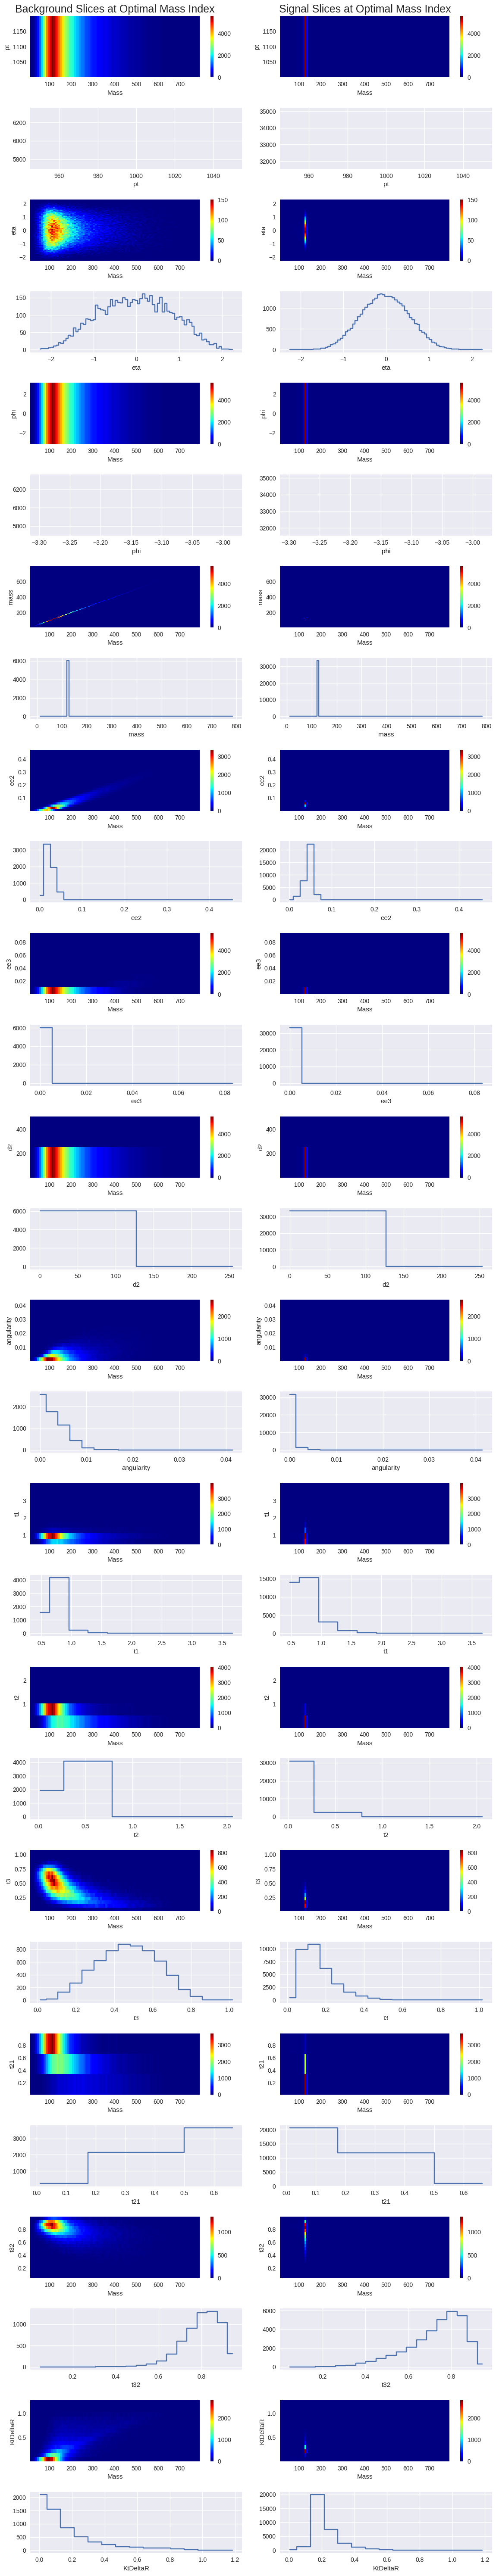

In [129]:
fig, ax = plt.subplots(len(keys)*2, 2, figsize=(12, 60))
fig.tight_layout(pad=3)

j = 0
k = 1
l = 0

for key in keys:
    y_var = key

    index = 14
    optimal_bins = 97
    
    var_bins = optimal_bin_num[l]

    x_low = background_dict['mass'].min()
    x_high = background_dict['mass'].max()

    y_low = background_dict[y_var].min()
    y_high = background_dict[y_var].max()

    b = ax[j,0].hist2d(background_dict['mass'], background_dict[y_var], bins=(optimal_bins, var_bins), 
                       cmap=plt.cm.jet, range=([x_low, x_high], [y_low, y_high]))
    plt.colorbar(b[3], ax=ax[j,0])

    c = ax[j,1].hist2d(signal_dict['mass'], signal_dict[y_var], bins=(optimal_bins, var_bins), 
                       cmap=plt.cm.jet, range=([x_low, x_high], [y_low, y_high]))
    
    plt.colorbar(b[3], ax=ax[j,1])

    qcd_weight = (2000/2050) * (100000 / np.sum(c[0]))
    higgs_weight = (50/2050) * (100000 / np.sum(b[0]))

    ax[j,0].set_xlabel("Mass")
    ax[j,0].set_ylabel(y_var)

    ax[j,1].set_xlabel("Mass")
    ax[j,1].set_ylabel(y_var)

    bkg_slice = b[0][index]
    higgs_slice = c[0][index]

    bkg_weight = (2000/2050) * (100000 / np.sum(higgs_slice))
    bkg_slice = bkg_slice*bkg_weight
    x = np.linspace(b[2][0], b[2][-2], var_bins)
    ax[k,0].step(x, bkg_slice, where='mid')
    ax[k,0].set_xlabel(y_var)

    higgs_weight = (50/2050) * (100000 / np.sum(bkg_slice))
    higgs_slice = higgs_slice * higgs_weight
    x = np.linspace(c[2][0], c[2][-2], var_bins)
    ax[k,1].step(x, higgs_slice, where='mid')
    ax[k,1].set_xlabel(y_var)
        
    l = l+1
    j = j+2
    k = k+2
    
    expected_sig = []
    for i in range(len(bkg_slice)):
        qcd = bkg_slice[i] 
        higgs = higgs_slice[i] 
        prob = stats.poisson.cdf(qcd+higgs, qcd, loc=0)
        expected_sig.append(stats.norm.ppf(prob, loc=0, scale=1))

    expected_sig = np.array(expected_sig)
    expected_sig[np.isinf(expected_sig)] = 0

    print(str(key)+": expected sig "+str(round(expected_sig.max(),3)))
    low_index = np.where(expected_sig == expected_sig.max())[0]
    high_index = low_index + 1
    print("from "+str(round(b[2][low_index][0],3))+" to "+str(round(b[2][high_index][0],3)))
    print("--------")
    
ax[0,0].set_title("Background Slices at Optimal Mass Index", fontsize=18)
ax[0,1].set_title("Signal Slices at Optimal Mass Index", fontsize=18)
plt.show()

Only eta, angularity, and KtdeltaR have significances higher than 5.

### Experimental Data
#### Read in the high and low luminosity experimental data sets

In [134]:
high_lumi_dict = pd.read_hdf('data_highLumi_pt_1000_1200.h5')
low_lumi_dict = pd.read_hdf('data_lowLumi_pt_1000_1200.h5')

qcd = background_dict
higgs = signal_dict

In [135]:
n_higgs_high = (50 / (50 + 2000)) * (len(high_lumi_dict['mass']) / len(higgs['mass']))
n_qcd_high = (2000 / (50 + 2000)) * (len(high_lumi_dict['mass']) / len(qcd['mass']))

qcd_weight_high = np.array([n_qcd_high] * len(qcd['mass']))
higgs_weight_high = np.array([n_higgs_high] * len(higgs['mass']))

n_higgs_low = (50 / (50 + 2000)) * (len(low_lumi_dict['mass']) / len(higgs['mass']))
n_qcd_low = (2000 / (50 + 2000)) * (len(low_lumi_dict['mass']) / len(qcd['mass']))

qcd_weight_low = np.array([n_qcd_low] * len(qcd['mass']))
higgs_weight_low = np.array([n_higgs_low] * len(higgs['mass']))

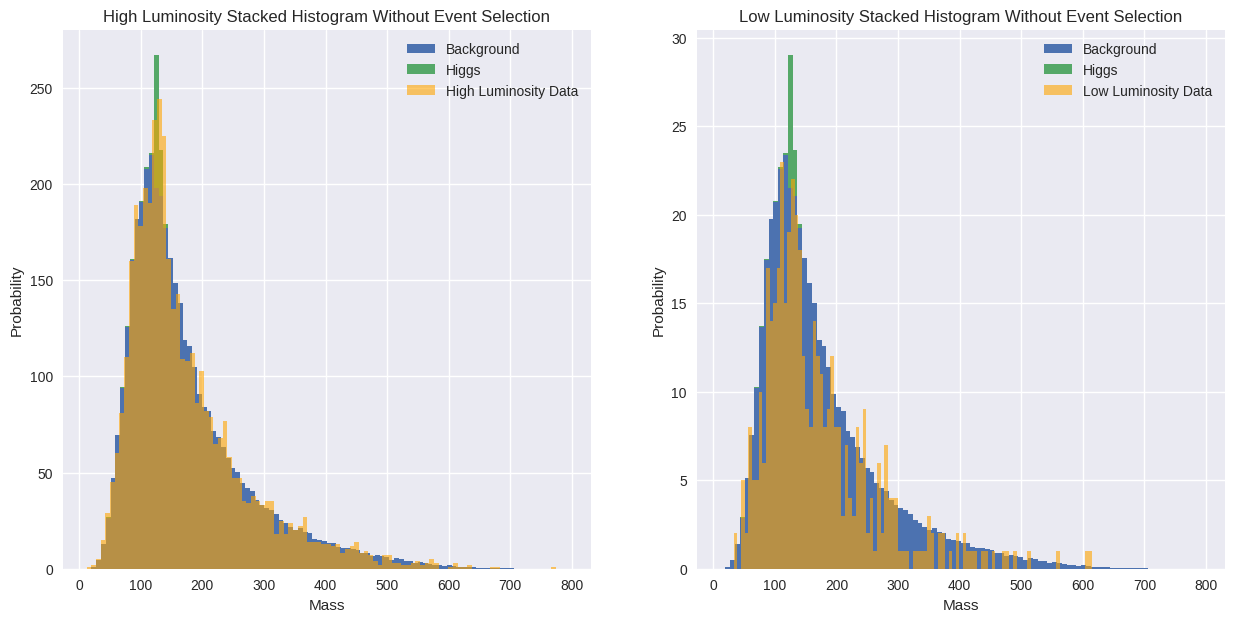

In [136]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))

a = ax[0].hist([qcd['mass'], higgs['mass']], bins = 100, density = False, 
               stacked = True, weights = [qcd_weight_high, higgs_weight_high], label=["Background", "Higgs"])
ax[0].hist(high_lumi_dict['mass'], bins = 100, density = False, alpha = .6, color = "orange", label="High Luminosity Data")

ax[0].legend(loc=0)
ax[0].set_title("High Luminosity Stacked Histogram Without Event Selection")
ax[0].set_xlabel("Mass")
ax[0].set_ylabel("Probability")


b = ax[1].hist([qcd['mass'], higgs['mass']], bins = 100, density = False, 
               stacked = True, weights = [qcd_weight_low, higgs_weight_low], label=["Background", "Higgs"])
ax[1].hist(low_lumi_dict['mass'], bins = 100, density = False, alpha = .6, color = "orange", label="Low Luminosity Data")

ax[1].legend(loc=0)
ax[1].set_title("Low Luminosity Stacked Histogram Without Event Selection")
ax[1].set_xlabel("Mass")
ax[1].set_ylabel("Probability")

plt.show()

### High Luminosity

##### Examine at the cuts determined earlier

##### Mass: 124.56 to 132.60

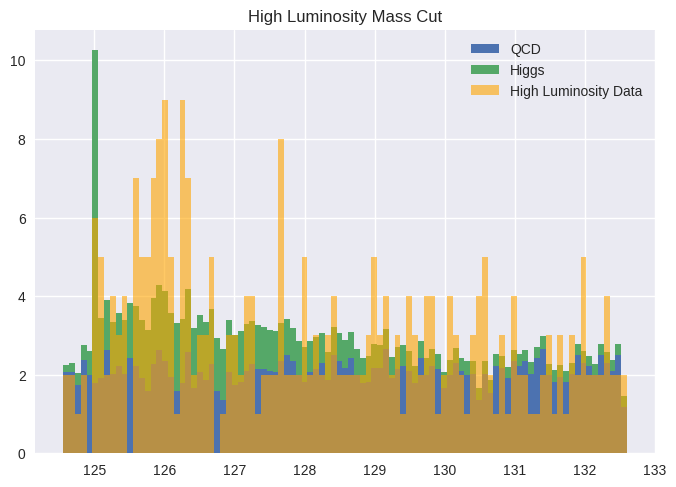

In [150]:
fig, ax = plt.subplots(1,1)

start = 124.56
stop = 132.60
optimal_bins = 97

ax.hist([qcd['mass'], higgs['mass']], bins = optimal_bins, density = False, stacked = True, 
            weights = [qcd_weight_high, higgs_weight_high], range = [start, stop], label=["QCD", "Higgs"])

ax.hist(high_lumi_dict['mass'], bins = optimal_bins, density = False, alpha = .6, 
        color = "orange", label="High Luminosity Data", range = [start, stop])

ax.set_title("High Luminosity Mass Cut")

ax.legend(loc=0)
plt.show()

The mass cut above shows the optimal range in which to evaluate the experimental data. This was perfomred on eta, angularity, and KtDeltaR, as these three were above a signficance of 5 in the previous section. 

This procedure is similar to above. I made 2D histograms of each data set - background (qcd), signal (higgs), and experimental data - with mass plotted against the three features in question. Then I made slices at the optimal mass index, counted the number of occurances, and calculated signficance. 

The high luminosity data produced a significance of **5.845$\sigma$**.

Significance of eta high luminosity = 5.845
Significance of angularity high luminosity = 5.845
Significance of KtDeltaR high luminosity = 5.845


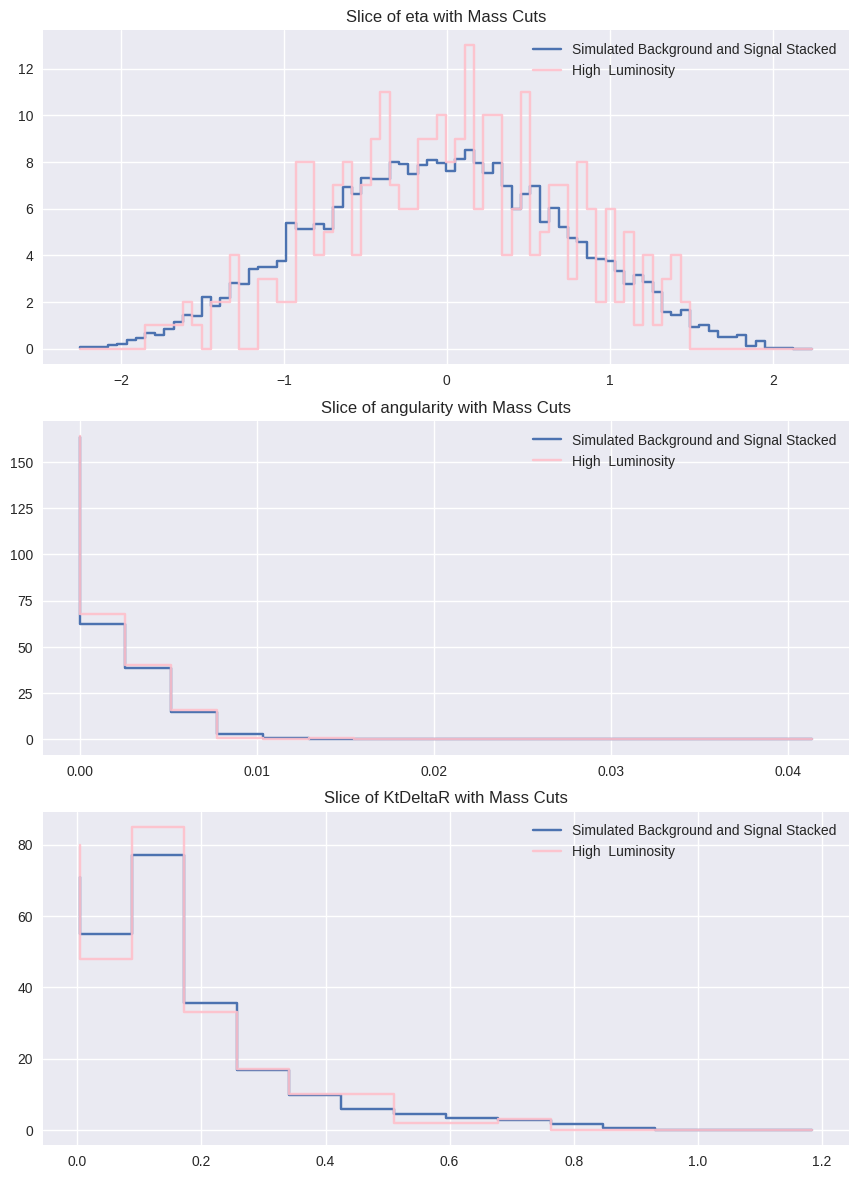

In [151]:
optimal_keys = ['eta', 'angularity', 'KtDeltaR']
optimal_keys_bins = [79, 17, 15]

fig, ax = plt.subplots(1, 1)
plt.close()
fig2, ax2 = plt.subplots(len(optimal_keys), 1, figsize=(9,12))
fig2.tight_layout(pad=2)

i = 0

for key in optimal_keys:
    
    var = key

    mass_lower = qcd['mass'].min()
    mass_upper = qcd['mass'].max()

    var_lower = qcd[var].min()
    var_upper = qcd[var].max()

    mass_bins = 97
    mass_slice = 14
    var_bins = optimal_keys_bins[i]

    hist_qcd = ax.hist2d(qcd['mass'], qcd[var], bins = [mass_bins, var_bins], 
                         range = [[mass_lower, mass_upper], [var_lower, var_upper]], density = False, weights = qcd_weight_high)
    hist_higgs = ax.hist2d(higgs['mass'], higgs[var], bins = [mass_bins, var_bins], 
                           range = [[mass_lower, mass_upper], [var_lower, var_upper]], density = False, weights = higgs_weight_high)
    hist_lumi = ax.hist2d(high_lumi_dict['mass'], high_lumi_dict[var], [mass_bins, var_bins], 
                          range = [[mass_lower, mass_upper], [var_lower, var_upper]], density = False)

    qcd_slice = hist_qcd[0][mass_slice]
    higgs_slice = hist_higgs[0][mass_slice]
    lumi_slice = hist_lumi[0][mass_slice]

    ax2[i].step(hist_qcd[2][0:var_bins], (qcd_slice + higgs_slice), alpha = 1, label = "Simulated Background and Signal Stacked")
    ax2[i].step(hist_lumi[2][0:var_bins], lumi_slice, color = 'pink', alpha = .9, label="High  Luminosity")
    ax2[i].set_title("Slice of "+str(var)+" with Mass Cuts")
    ax2[i].legend(loc=0)

    n_experiment = np.sum(lumi_slice)
    n_background = np.sum(qcd_slice)
    sig = stats.norm.ppf(stats.poisson.cdf(n_experiment, n_background, loc = 0))  # stats.poisson.cdf(k, mu, loc=0)
    print("Significance of "+str(var)+" high luminosity = " +str(round(sig,3)))
    
    i = i+1

### Low Luminosity

##### Examine at the cuts determined earlier

##### Mass: 124.56 to 132.60

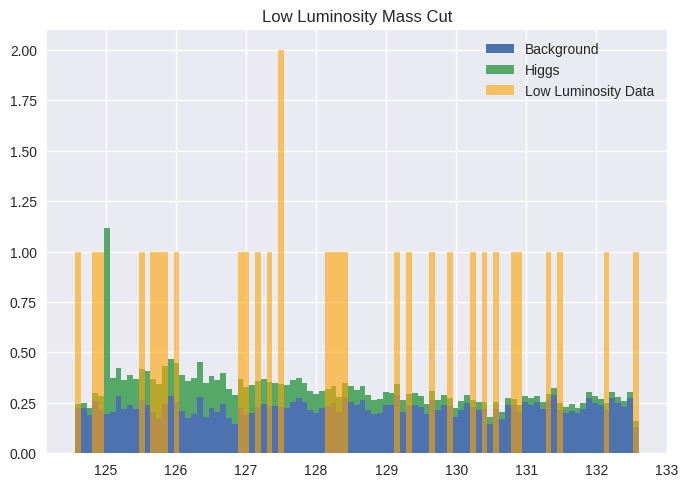

In [152]:
fig, ax = plt.subplots(1,1)

start = 124.56
stop = 132.60
optimal_bins = 97

ax.hist([qcd['mass'], higgs['mass']], bins = optimal_bins, density = False, stacked = True, 
            weights = [qcd_weight_low, higgs_weight_low], range = [start, stop], label=["Background", "Higgs"])

ax.hist(low_lumi_dict['mass'], bins = optimal_bins, density = False, alpha = .6, 
        color = "orange", label="Low Luminosity Data", range = [start, stop])

ax.set_title("Low Luminosity Mass Cut")

ax.legend(loc=0)
plt.show()

Significance of eta low luminosity = 1.942
Significance of angularity low luminosity = 1.942
Significance of KtDeltaR low luminosity = 1.942


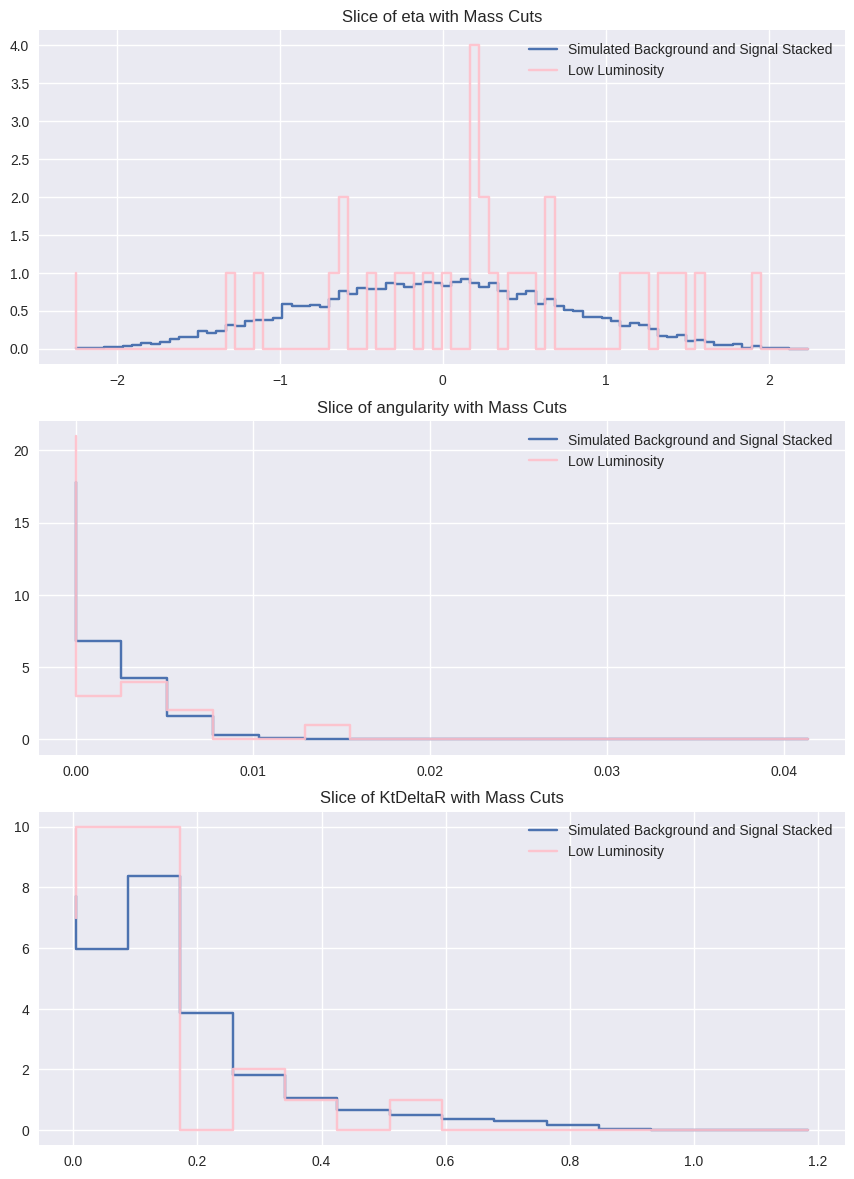

In [155]:
fig, ax = plt.subplots(1, 1)
plt.close()
fig2, ax2 = plt.subplots(len(optimal_keys), 1, figsize=(9,12))
fig2.tight_layout(pad = 2)

i = 0
for key in optimal_keys:
    
    var = key

    mass_lower = qcd['mass'].min()
    mass_upper = qcd['mass'].max()

    var_lower = qcd[var].min()
    var_upper = qcd[var].max()

    mass_bins = 97
    mass_slice = 14
    var_bins = optimal_keys_bins[i]

    hist_qcd = ax.hist2d(qcd['mass'], qcd[var], bins = [mass_bins, var_bins], 
                         range = [[mass_lower, mass_upper], [var_lower, var_upper]], density = False, weights = qcd_weight_low)
    hist_higgs = ax.hist2d(higgs['mass'], higgs[var], bins = [mass_bins, var_bins], 
                           range = [[mass_lower, mass_upper], [var_lower, var_upper]], density = False, weights = higgs_weight_low)
    hist_lumi = ax.hist2d(low_lumi_dict['mass'], low_lumi_dict[var], [mass_bins, var_bins], 
                          range = [[mass_lower, mass_upper], [var_lower, var_upper]], density = False)

    qcd_slice = hist_qcd[0][mass_slice]
    higgs_slice = hist_higgs[0][mass_slice]
    lumi_slice = hist_lumi[0][mass_slice]

    ax2[i].step(hist_qcd[2][0:var_bins], (qcd_slice + higgs_slice), alpha = 1, label = "Simulated Background and Signal Stacked")
    ax2[i].step(hist_lumi[2][0:var_bins], lumi_slice, color = 'pink', alpha = .9, label = "Low Luminosity")
    ax2[i].set_title("Slice of "+str(var)+" with Mass Cuts")
    ax2[i].legend(loc=0)

    n_experiment = np.sum(lumi_slice)
    n_background = np.sum(qcd_slice)
    sig = stats.norm.ppf(stats.poisson.cdf(n_experiment, n_background, loc = 0))  # stats.poisson.cdf(k, mu, loc=0)
    print("Significance of "+str(var)+" low luminosity = " +str(round(sig,3)))
    
    i = i+1

##### Significance: high luminosity = 5.85, low luminosity = 1.94